# MobileHCI 2018 tutorial: Machine Learning for Intelligent Mobile User Interfaces using Keras

In [8]:
# -*- coding: utf-8 -*-

## By Abdallah El Ali
## MobileHCI 2018 tutorial: Machine Learning for Intelligent Mobile User Interfaces using Keras
## 02_model-training: Config, train, and evaluate your (mixed conv) recurrent neural network

## Some code adapted from: GUILLAUME CHEVALIER https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition

import tensorflow as tf
from tensorflow.python.framework import graph_util, graph_io
from tensorflow.python.tools import freeze_graph

from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LSTM, LSTMCell, Bidirectional, TimeDistributed, InputLayer, ConvLSTM2D
from keras import optimizers
from keras import backend as K

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html#sklearn.model_selection.LeaveOneGroupOut

from scipy import stats
import scipy.io

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm
import seaborn as sns
import pickle
import math
# from mpl_toolkits.mplot3d import Axes3D
import pylab
import os
import os.path as osp
import wget
import zipfile
import warnings

# warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# graph = tf.get_default_graph()
K.clear_session()

In [13]:
## install all necessary python 3.6 packages
# !pip3 install -r requirements.txt

In [1]:
## convert Jupyter notebook to a README for GitHub repo's main page
# !jupyter nbconvert --to markdown 02_model-training.ipynb
# !mv 02_model-training.md README.md

In [2]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'


# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.1

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [15]:
## check tensorflow version
!python3 -W ignore -c 'import tensorflow as tf; print(tf.__version__)'  # for Python 3

## check python version
!python3 --version

## check matplotlib version
!python3 -c 'import matplotlib; print(matplotlib.__version__, matplotlib.__file__)'


## gradle TF build repo
# https://mvnrepository.com/artifact/org.tensorflow/tensorflow-android/1.5.0-rc1

1.9.0
Python 3.6.5
2.2.3 /home/abdo/.local/lib/python3.6/site-packages/matplotlib/__init__.py


### Config your ConvLSTM

In [3]:
## UNCOMMENT below line for segmenting the signal in overlapping windows of 90 samples with 50% overlap
# segments, labels, subjects = segment_signal(df)

## COMMENT below segments + labels files if you want to segment afresh . open a file, where you stored the pickled data
segments = pickle.load(open('./data/segments_90_logo.p', 'rb'), encoding='latin1')
labels = pickle.load(open('./data/labels_90_logo.p','rb'), encoding='latin1')
subjects = pickle.load(open('./data/subjects_90_logo.p','rb'),encoding='latin1')

## dump information to that file (UNCOMMENT to save fresh segmentation!)
# pickle.dump(segments, open( './data/segments_90_logo.p','wb'))
# pickle.dump(labels, open( './data/labels_90_logo.p','wb'))
# pickle.dump(subjects, open( './data/subjects_90_logo.p','wb'))

# segments, labels, subjects = segment_signal(df)
groups = np.array(subjects)

logo = LeaveOneGroupOut()
logo.get_n_splits(segments, labels, groups)

## defining parameters for the input and network layers
## we are treating each segmeent or chunk as a 2D image (90 X 3)
numOfRows = segments.shape[1]
numOfColumns = segments.shape[2]

## reshaping the data for network input
reshapedSegments = segments.reshape(segments.shape[0], numOfRows, numOfColumns,1)
## (observations, timesteps, features (x,y,z), channels)

# categorically defining the classes of the activities
labels = np.asarray(pd.get_dummies(labels),dtype = np.int8)

In [4]:
## ConvLSTM net hyperparameters

numChannels = 1
numFilters = 128 # number of filters in Conv2D layer
# kernal size of the Conv2D layer
kernalSize1 = 2
# max pooling window size
poolingWindowSz = 2
# number of filters in fully connected layers
numNueronsFCL1 = 128
numNueronsFCL2 = 128
# number of epochs
Epochs = 10
# batchsize
batchSize = 10
# number of total classes
numClasses = labels.shape[1]
# dropout ratio for dropout layer
dropOutRatio = 0.2

## number of total clases
numClasses = labels.shape[1]
print(labels.shape)
print(numClasses)

(62476, 12)
12


In [32]:
print('segments shape:' + str(segments.shape))
print('labels shape:' + str(labels.shape))
print('\n')
print('Rows / Timesteps: ' + str(numOfRows))
print('Columns / features: ' + str(numOfColumns))

## key:
## Conv2D: (observations, timesteps, features (acc + gyro), channels)
## LSTM: (batch size, observations, timesteps, features (acc + gyro), channels)

segments shape:(62476, 90, 6)
labels shape:(62476, 12)


Rows / Timesteps: 90
Columns / features: 6


In [5]:
def Conv2D_LSTM_Model():
    model = Sequential()
    print(model.name)

    # adding the first convLSTM layer with 32 filters and 5 by 5 kernal size, using the rectifier as the activation function
    model.add(ConvLSTM2D(numFilters, (kernalSize1,kernalSize1),input_shape=(None, numOfRows, numOfColumns, 1),activation='relu', padding='same',return_sequences=True))
    print(model.input_shape)
    print(model.output_shape)
    print(model.name)
    
    ## adding a maxpooling layer
    model.add(TimeDistributed(MaxPooling2D(pool_size=(poolingWindowSz,poolingWindowSz),padding='valid')))
    print(model.output_shape)

    ## adding a dropout layer for the regularization and avoiding over fitting
    model.add(Dropout(dropOutRatio))
    print(model.output_shape)
    
    ## flattening the output in order to apple dense layer
    model.add(TimeDistributed(Flatten()))
    print(model.output_shape)
    
    ## adding first fully connected layer with 256 outputs
    model.add(Dense(numNueronsFCL1, activation='relu'))
    print(model.output_shape)

    ## adding second fully connected layer 128 outputs
    model.add(Dense(numNueronsFCL2, activation='relu'))
    print(model.output_shape)

    ## flattening the output in order to apply the fully connected layer
    model.add(TimeDistributed(Flatten()))
    print(model.output_shape)

    ## adding softmax layer for the classification
    model.add(Dense(numClasses, activation='softmax'))
    print(model.output_shape)
    print(model.name)

    ## Compiling the model to generate a model
    adam = optimizers.Adam(lr = 0.001, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

### Train, evaluate & save your network

In [6]:
## Leave One Group Out for train-test split, and train the network!

## NOTE: training with Epochs=2 and BatchSize=32 for illustrative purposes.  

## reset and initialize graph
tf.get_default_graph()

if not os.path.exists('./train_history'):
    os.makedirs('./train_history')
    
cvscores = []

for index, (train_index, test_index) in enumerate(logo.split(reshapedSegments, labels, groups)):

    print('Training on fold ' + str(index+1) + '/14...') ## 14 due to number of subjects in our dataset

    # print('TRAIN:', train_index, 'TEST:', test_index)
    trainX, testX = reshapedSegments[train_index], reshapedSegments[test_index]
    trainY, testY = labels[train_index], labels[test_index]
    # print(np.nan_to_num(trainX), np.nan_to_num(testX), trainY, testY)

    ## clear model, and create it
    model = None
    model = Conv2D_LSTM_Model()

    for layer in model.layers:
        print(layer.name)
    print(trainX.shape)

    ## fit the model
    history = model.fit(np.expand_dims(trainX,1),np.expand_dims(trainY,1), validation_data=(np.expand_dims(testX,1),np.expand_dims(testY,1)), epochs=Epochs,batch_size=batchSize,verbose=2)
    
    with open('train_history/train_history_dict_' + str(index), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    ## evaluate the model
    score = model.evaluate(np.expand_dims(testX,1),np.expand_dims(testY,1),verbose=2)
    print('%s: %.2f%%' % (model.metrics_names[1], score[1]*100))
    print('Baseline ConvLSTM Error: %.2f%%' %(100-score[1]*100))
    cvscores.append(score[1] * 100)

print('%.2f%% (+/- %.2f%%)' % (np.mean(cvscores), np.std(cvscores)))

## Save your model!
model.save('model_had_lstm_logo.h5')
model.save_weights('model_weights_had_lstm_logo.h5')
np.save('groundTruth_had_lstm_logo.npy',np.expand_dims(testY,1))
np.save('testData_had_lstm_logo.npy',np.expand_dims(testX,1))

## write to JSON, in case you wanrt to work with that data format later when inspecting your model
with open('./data/model_had_logo.json', 'w') as json_file:
    json_file.write(model.to_json())

## write cvscores to file
with open('train_history/cvscores_convlstm_logo.txt', 'w') as cvs_file:
    cvs_file.write('%.2f%% (+/- %.2f%%)' % (np.mean(cvscores), np.std(cvscores)))

Training on fold 1/14...
sequential_1
(None, None, 90, 6, 1)
(None, None, 90, 6, 128)
sequential_1
(None, None, 45, 3, 128)
(None, None, 45, 3, 128)
(None, None, 17280)
(None, None, 128)
(None, None, 128)
(None, None, 128)
(None, None, 12)
sequential_1
conv_lst_m2d_1
time_distributed_1
dropout_1
time_distributed_2
dense_1
dense_2
time_distributed_3
dense_3
(58134, 90, 6, 1)
Train on 58134 samples, validate on 4342 samples
Epoch 1/2
 - 63s - loss: 0.6747 - acc: 0.7545 - val_loss: 0.7456 - val_acc: 0.7096
Epoch 2/2
 - 61s - loss: 0.4439 - acc: 0.8320 - val_loss: 0.7153 - val_acc: 0.7446
acc: 74.46%
Baseline ConvLSTM Error: 25.54%
Training on fold 2/14...
sequential_2
(None, None, 90, 6, 1)
(None, None, 90, 6, 128)
sequential_2
(None, None, 45, 3, 128)
(None, None, 45, 3, 128)
(None, None, 17280)
(None, None, 128)
(None, None, 128)
(None, None, 128)
(None, None, 12)
sequential_2
conv_lst_m2d_2
time_distributed_4
dropout_2
time_distributed_5
dense_4
dense_5
time_distributed_6
dense_6
(5693

Epoch 2/2
 - 62s - loss: 0.4320 - acc: 0.8344 - val_loss: 1.2255 - val_acc: 0.6732
acc: 67.32%
Baseline ConvLSTM Error: 32.68%
Training on fold 14/14...
sequential_14
(None, None, 90, 6, 1)
(None, None, 90, 6, 128)
sequential_14
(None, None, 45, 3, 128)
(None, None, 45, 3, 128)
(None, None, 17280)
(None, None, 128)
(None, None, 128)
(None, None, 128)
(None, None, 12)
sequential_14
conv_lst_m2d_14
time_distributed_40
dropout_14
time_distributed_41
dense_40
dense_41
time_distributed_42
dense_42
(56682, 90, 6, 1)
Train on 56682 samples, validate on 5794 samples
Epoch 1/2
 - 64s - loss: 0.6974 - acc: 0.7432 - val_loss: 0.4632 - val_acc: 0.8293
Epoch 2/2
 - 62s - loss: 0.4450 - acc: 0.8306 - val_loss: 0.4020 - val_acc: 0.8366
acc: 83.66%
Baseline ConvLSTM Error: 16.34%
70.93% (+/- 9.51%)


In [ ]:
## shape of data to feed frozen model later in Android code
# print(testX[[1]].shape)

### Evaluate model, and plot confusion matrix + acc/loss graphs

In [7]:
## the acc of our combined 'logo' models is 71.74%!
with open('./train_history/cvscores_convlstm_logo.txt', 'r') as cvs_scores:
    cvs = cvs_scores.read()
print(cvs)

70.93% (+/- 9.51%)


Loaded model from disk
acc: 78.81%
Baseline Error: 21.19%
[[ 57 174   0   1  64   0  47   0   0   1   0   0]
 [ 54 213   1   0  24   0  47   1   2   0   1   1]
 [  0   0 163  14   0   0   0   3   1   0   0   2]
 [  0   0   1 322   0   0   1   1   2   0   0   4]
 [ 41  57   0   0 127   0 131   0   0   0   0   0]
 [  0   0   0   0   0 555   0   0   0   0   1   0]
 [  3   0   6   0  21   0 186   4  75   0   3  13]
 [  0   0  63   1   0   0   1 464  54  66   0  48]
 [  0   0   0   0   0   0   2   3 871  28  39   1]
 [  0   0   0   0   0   0   2   4  51 439   4   0]
 [  0   0   0   0   0   0   3   0  21   0 435   2]
 [  0   0   0   0   0   0   2   3  21   0   7 734]]
Accuracy for each class is given below.
('WalkForward :', 16.57, '%')
('WalkLeft    :', 61.92, '%')
('WalkRight   :', 89.07, '%')
('WalkUp      :', 97.28, '%')
('WalkDown    :', 35.67, '%')
('RunForward  :', 99.82, '%')
('JumpUp      :', 59.81, '%')
('Sit         :', 66.57, '%')
('Stand       :', 92.27, '%')
('Sleep       :', 8

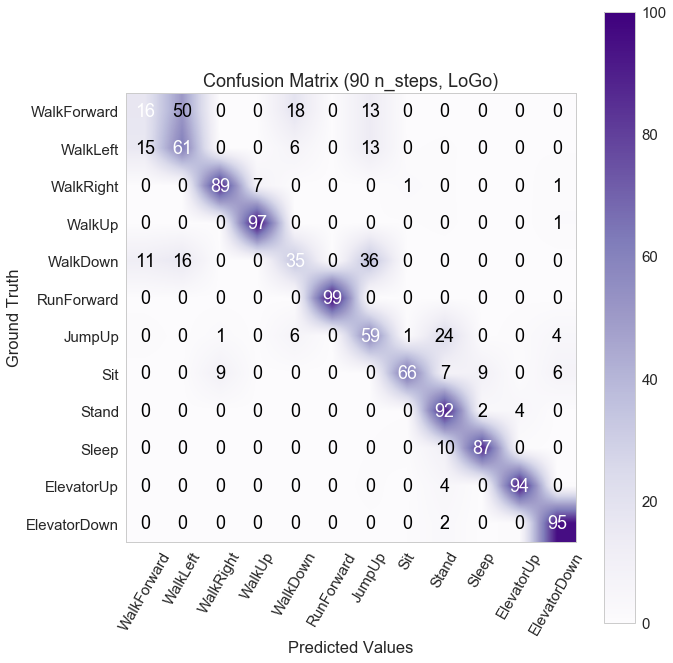

In [11]:
# %%pixie_debugger
# -*- coding: utf-8 -*-
'''
Evaluate a pretrained model saved as *.h5 using 'testData_X.npy'
and 'groundTruth_X.npy'. Error reported is the cross entropy loss in percentage. Also generates a png file for the confusion matrix.
Based on work by Muhammad Shahnawaz.

NOTE: keep in mind we are only looking at Model 14 given our 'logo' approach! 
'''

if not os.path.exists('./plots'):
    os.makedirs('./plots')

## define a function for plotting the confusion matrix
## takes cmNormalized
os.environ['QT_PLUGIN_PATH'] = ''
def plot_cm(cM, labels,title):
    
    plt.close()
    ## normalizing the confusionMatrix for showing the probabilities
    cmNormalized = np.around((cM/cM.astype(np.float).sum(axis=1)[:,None])*100,2)
    ## creating a figure object
    fig = plt.figure(figsize=(10,10))
    ## plotting the confusion matrix
    plt.imshow(cmNormalized,interpolation='bilinear',cmap = plt.cm.Purples)
    ## creating a color bar and setting the limits
    plt.colorbar()
    plt.clim(0,100)
    ## assiging the title, x and y labels
    plt.xlabel('Predicted Values')
    plt.ylabel('Ground Truth')
    plt.title(title + '')
    ## defining the ticks for the x and y axis
    plt.xticks(range(len(labels)),labels,rotation = 60)
    plt.yticks(range(len(labels)),labels)
    ## number of occurences in the boxes
    width, height = cM.shape
    print('Accuracy for each class is given below.')
    for predicted in range(width):
        for real in range(height):
            color = 'black'
            if(predicted == real):
                color = 'white'
                print(labels[predicted].ljust(12)+ ':', cmNormalized[predicted,real], '%')
            plt.gca().annotate(
                    '{:d}'.format(int(cmNormalized[predicted,real])),xy=(real, predicted),
                    horizontalalignment = 'center',verticalalignment = 'center',color = color)

    ## making sure that the figure is not clipped
    plt.tight_layout()
    plt.grid('off')
    ## save the figure
    fig.savefig(title +'.png')
    
## loading the pretrained model
model = load_model('./data/model_had_lstm_logo.h5')

## load weights into new model
model.load_weights('./data/model_weights_had_lstm_logo.h5')
print('Loaded model from disk')

## loading the testData and groundTruth data
test_x = np.load('./data/testData_had_lstm_logo.npy')
groundTruth = np.load('./data/groundTruth_had_lstm_logo.npy')

## evaluate loaded model on test data
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = model.evaluate(test_x,groundTruth,verbose=2)

## print out values for metrics
print('%s: %.2f%%' % (model.metrics_names[1], score[1]*100))
print('Baseline Error: %.2f%%' %(100-score[1]*100))

## Creating and plotting a confusion matrix

## defining the 12 class labels
labels = ['WalkForward','WalkLeft','WalkRight','WalkUp','WalkDown','RunForward', 'JumpUp', 'Sit', 'Stand', 'Sleep', 'ElevatorUp', 'ElevatorDown']

## predicting the classes
predictions = model.predict(test_x,verbose=2)

## getting the class predicted and class in ground truth for creation of confusion matrix
predictedClass = np.zeros((predictions.shape[0]))
groundTruthClass = np.zeros((groundTruth.shape[0]))

for instance in range (groundTruth.shape[0]):
    predictedClass[instance] = np.argmax(predictions[instance,:])
    groundTruthClass[instance] = np.argmax(groundTruth[instance,:])

cm = metrics.confusion_matrix(groundTruthClass,predictedClass)

print(cm)

## plotting the confusion matrix
plot_cm(cm, labels,'Confusion Matrix (90 n_steps, LoGo)')

print(model.summary())


['acc', 'loss', 'val_acc', 'val_loss']


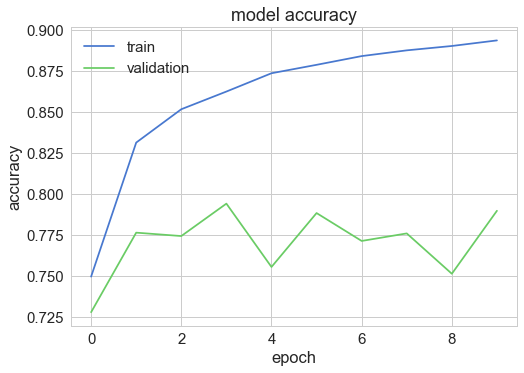

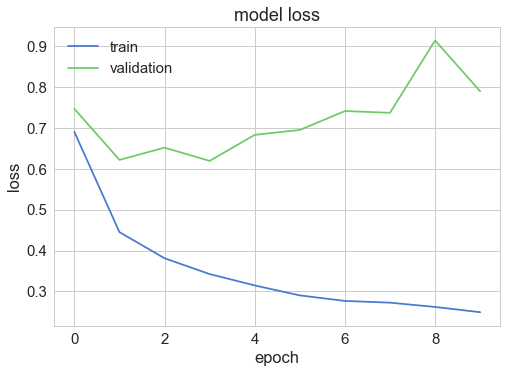

In [6]:
## plot acc and loss plot of last stored model weights in history variable

## load model history (models 1-14). Below we load the last 'logo' model 
history = pickle.load(open('./train_history/train_history_dict_0','rb'))

print(history.keys())

## plot train+val accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig('./plots/acc_plot_logo.pdf', bbox_inches='tight')

## plot train+val loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig('./plots/loss_plot_logo.pdf', bbox_inches='tight')